# Automatic disease identification from free text

## NCBI disease corpus

* dataset is split into training, development, and test set
* each word will be tagged as one of the labels (“B”, “I”, and “O”). 
* the data can be found at https://github.com/cambridgeltl/MTL-Bioinformatics-2016/tree/master/data
* the data is converted into CoNLL format where Word lines contains the annotation, blank lines marking sentence boundaries.
    
## Emerging trends in NLP for NER
1. Biderectional LSTM-CRF
2. Bidirectional LSTM-CNNs
3. Bidirectional LSTM-CNNS-CRF
4. ELMo
5. BERT

## Today Demo

- Bidirectional LSTM-CNN

Chiu, J. P., & Nichols, E. (2016). Named entity recognition with bidirectional LSTM-CNNs. Transactions of the Association for Computational Linguistics, 4, 357-370.

### Model architecture

The BLSTM layer forms the core of the network and has the following three inputs:

   - Character-level patters are identified by a convolutional neural network
   - Word-level input from GloVE embeddings
   - Casing input (whether words are lower case, upper case, etc.)

The graph below shows the model architecture with all layers. A softmax activation layer generates the final outputs.


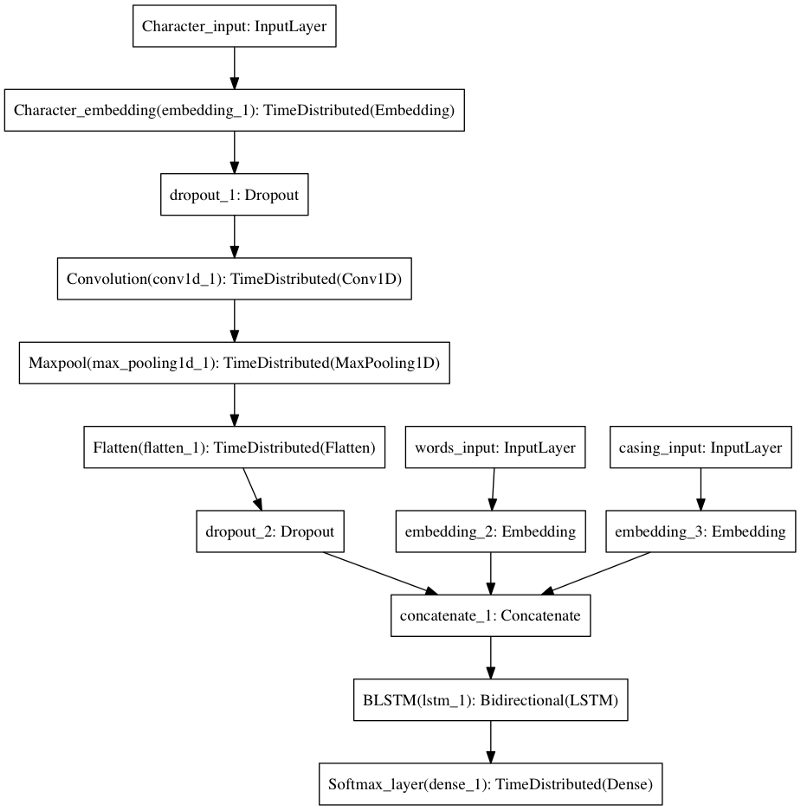

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import pandas as pd
import os

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Model
from keras.layers import TimeDistributed,Conv1D,Dense,Embedding,Input,Dropout,LSTM,Bidirectional,MaxPooling1D,Flatten,concatenate
from keras.utils import Progbar
from keras.preprocessing.sequence import pad_sequences
from keras.initializers import RandomUniform


Using TensorFlow backend.


In [2]:
path = os.getcwd() 
parent = os.path.dirname(os.getcwd())
data_dir = path + '/NERdata/NCBI-disease'

Let's explore the data

In [3]:
def read_data(input_file):
    data = pd.DataFrame(columns = ['Sentence #','Word','Tag'])
                                   
    """Reads a BIO data."""
    with open(input_file) as f:
        lines = []
        words = []
        labels = []
        sencounter = 0
        for line in f:
            contends = line.strip()
            if len(contends) == 0:
                assert len(words) == len(labels)
                if len(words) > 30:
                    while len(words) > 30:
                        tmplabel = labels[:30]
                        for iidx in range(len(tmplabel)):
                            if tmplabel.pop() == 'O':
                                 break
                        l = ' '.join([label for label in labels[:len(tmplabel)+1] if len(label) > 0])
                        w = ' '.join([word for word in words[:len(tmplabel)+1] if len(word) > 0])
                        lines.append([l, w])
                        words = words[len(tmplabel)+1:]
                        labels = labels[len(tmplabel)+1:]

                if len(words) == 0:
                    continue
                l = ' '.join([label for label in labels if len(label) > 0])
                w = ' '.join([word for word in words if len(word) > 0])
                lines.append([l, w])
                words = []
                labels = []
                sencounter +=1
                continue
            if sencounter == 100:
                break
            word = line.strip().split()[0]
            label = line.strip().split()[-1]
            data_ = {}
            data_['Word'] = word
            data_['Tag'] = label
            data_['Sentence #'] = 'Sentence: ' + str(sencounter)
            data = data.append(data_,ignore_index=True)
            words.append(word)
            labels.append(label)
            
        return data

In [4]:
# a list of all sentences int he 
data = read_data(os.path.join(data_dir, "train_dev.tsv"))    

In [5]:
data.head(30)

,Sentence #,Word,Tag
0,Sentence: 0,Identification,O
1,Sentence: 0,of,O
2,Sentence: 0,APC2,O
3,Sentence: 0,",",O
4,Sentence: 0,a,O
5,Sentence: 0,homologue,O
6,Sentence: 0,of,O
7,Sentence: 0,the,O
8,Sentence: 0,adenomatous,B
9,Sentence: 0,polyposis,I


In [6]:
def readfile(input_file):
    data = pd.DataFrame(columns = ['Sentence #','Word','Tag'])
                                   
    """Reads a BIO data."""
    with open(input_file) as f:
        lines = []
        words = []
        labels = []
        sentences = []
        sentence = []
        #sencounter = 0
        for line in f:
            contends = line.strip()
            if len(contends) == 0:
                assert len(words) == len(labels)
                if len(words) > 30:
                    while len(words) > 30:
                        tmplabel = labels[:30]
                        for iidx in range(len(tmplabel)):
                            if tmplabel.pop() == 'O':
                                 break
                        l = ' '.join([label for label in labels[:len(tmplabel)+1] if len(label) > 0])
                        w = ' '.join([word for word in words[:len(tmplabel)+1] if len(word) > 0])
                        lines.append([l, w])
                        words = words[len(tmplabel)+1:]
                        labels = labels[len(tmplabel)+1:]

                if len(words) == 0:
                    continue
                l = ' '.join([label for label in labels if len(label) > 0])
                w = ' '.join([word for word in words if len(word) > 0])
                lines.append([l, w])
                sentences.append(sentence)
                sentence = []
                words = []
                labels = []
                #sencounter +=1
                continue
#            if sencounter == 100:
#                break
            word = line.strip().split()[0]
            label = line.strip().split()[-1]
            sentence.append([word,label])
            #data_ = {}
            #data_['Word'] = word
#            data_['Tag'] = label
#            data_['Sentence #'] = 'Sentence: ' + str(sencounter)
#            data = data.append(data_,ignore_index=True)
            words.append(word)
            labels.append(label)
            
        return sentences
    

In [7]:
#sentence = readfile(os.path.join(data_dir, "train_dev.tsv"))
trainSentences = readfile(os.path.join(data_dir, "train.tsv"))
devSentences = readfile(os.path.join(data_dir, "devel.tsv"))
testSentences = readfile(os.path.join(data_dir, "test.tsv"))

In [8]:
def addCharInformatioin(Sentences):
    for i,sentence in enumerate(Sentences):
        for j,data in enumerate(sentence):
            chars = [c for c in data[0]]
            Sentences[i][j] = [data[0],chars,data[1]]
    return Sentences

In [9]:
trainSentences = addCharInformatioin(trainSentences)
devSentences = addCharInformatioin(devSentences)
testSentences = addCharInformatioin(testSentences)

In [10]:
trainSentences[:15]

[[['Identification',
   ['I', 'd', 'e', 'n', 't', 'i', 'f', 'i', 'c', 'a', 't', 'i', 'o', 'n'],
   'O'],
  ['of', ['o', 'f'], 'O'],
  ['APC2', ['A', 'P', 'C', '2'], 'O'],
  [',', [','], 'O'],
  ['a', ['a'], 'O'],
  ['homologue', ['h', 'o', 'm', 'o', 'l', 'o', 'g', 'u', 'e'], 'O'],
  ['of', ['o', 'f'], 'O'],
  ['the', ['t', 'h', 'e'], 'O'],
  ['adenomatous',
   ['a', 'd', 'e', 'n', 'o', 'm', 'a', 't', 'o', 'u', 's'],
   'B'],
  ['polyposis', ['p', 'o', 'l', 'y', 'p', 'o', 's', 'i', 's'], 'I'],
  ['coli', ['c', 'o', 'l', 'i'], 'I'],
  ['tumour', ['t', 'u', 'm', 'o', 'u', 'r'], 'I'],
  ['suppressor', ['s', 'u', 'p', 'p', 'r', 'e', 's', 's', 'o', 'r'], 'O'],
  ['.', ['.'], 'O']],
 [['The', ['T', 'h', 'e'], 'O'],
  ['adenomatous',
   ['a', 'd', 'e', 'n', 'o', 'm', 'a', 't', 'o', 'u', 's'],
   'B'],
  ['polyposis', ['p', 'o', 'l', 'y', 'p', 'o', 's', 'i', 's'], 'I'],
  ['coli', ['c', 'o', 'l', 'i'], 'I'],
  ['(', ['('], 'I'],
  ['APC', ['A', 'P', 'C'], 'I'],
  [')', [')'], 'I'],
  ['tumour',

In [11]:
labelSet = set()
words = {}

for dataset in [trainSentences, devSentences, testSentences]:
    for sentence in dataset:
        for token,char,label in sentence:
            labelSet.add(label)
            words[token.lower()] = True


In [12]:
# :: Create a mapping for the labels ::
label2Idx = {}
for label in labelSet:
    label2Idx[label] = len(label2Idx)


In [13]:
labelSet

{'B', 'I', 'O'}

In [14]:
# :: Hard coded case lookup ::
case2Idx = {'numeric': 0, 'allLower':1, 'allUpper':2, 'initialUpper':3, 'other':4, 'mainly_numeric':5, 'contains_digit': 6, 'PADDING_TOKEN':7}
caseEmbeddings = np.identity(len(case2Idx), dtype='float32')


## Embeddings
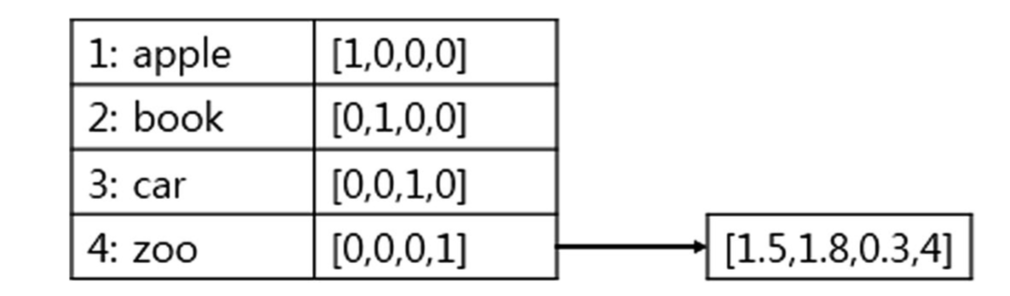

Source: Song, H. J., Jo, B. C., Park, C. Y., Kim, J. D., & Kim, Y. S. (2018). Comparison of named entity recognition methodologies in biomedical documents. Biomedical engineering online, 17(2), 158.

In [15]:
# config
GLOVE_DIR = os.path.join('glove.6B')
#TEXT_DATA_DIR = os.path.join(BASE_DIR, '20_newsgroup')
Max_Seq_Len = 100
max_vocab_size = 1000000
Embed_dim = 100
VALIDATION_SPLIT = 0.2

Create Word Embedding matrix

In [16]:
# :: Read in word embeddings ::
word2Idx = {}
wordEmbeddings = []

fEmbeddings = open("glove.6B/glove.6B.100d.txt")

for line in fEmbeddings:
    split = line.strip().split(" ")
    word = split[0]
    
    if len(word2Idx) == 0: #Add padding+unknown
        word2Idx["PADDING_TOKEN"] = len(word2Idx)
        vector = np.zeros(len(split)-1) #Zero vector vor 'PADDING' word
        wordEmbeddings.append(vector)
        
        word2Idx["UNKNOWN_TOKEN"] = len(word2Idx)
        vector = np.random.uniform(-0.25, 0.25, len(split)-1)
        wordEmbeddings.append(vector)

    if split[0].lower() in words:
        vector = np.array([float(num) for num in split[1:]])
        wordEmbeddings.append(vector)
        word2Idx[split[0]] = len(word2Idx)
        
wordEmbeddings = np.array(wordEmbeddings)


In [18]:
char2Idx = {"PADDING":0, "UNKNOWN":1}
for c in " 0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ.,-_()[]{}!?:;#'\"/\\%$`&=*+@^~|><":
    char2Idx[c] = len(char2Idx)

In [19]:
def padding(Sentences):
    maxlen = 52
    for sentence in Sentences:
        char = sentence[2]
        for x in char:
            maxlen = max(maxlen,len(x))
    for i,sentence in enumerate(Sentences):
        Sentences[i][2] = pad_sequences(Sentences[i][2],52,padding='post')
    return Sentences

In [20]:
def createMatrices(sentences, word2Idx, label2Idx, case2Idx,char2Idx):
    unknownIdx = word2Idx['UNKNOWN_TOKEN']
    paddingIdx = word2Idx['PADDING_TOKEN']    
        
    dataset = []
    
    wordCount = 0
    unknownWordCount = 0
    
    for sentence in sentences:
        wordIndices = []    
        caseIndices = []
        charIndices = []
        labelIndices = []
        
        for word,char,label in sentence:  
            wordCount += 1
            if word in word2Idx:
                wordIdx = word2Idx[word]
            elif word.lower() in word2Idx:
                wordIdx = word2Idx[word.lower()]                 
            else:
                wordIdx = unknownIdx
                unknownWordCount += 1
            charIdx = []
            for x in char:
                charIdx.append(char2Idx[x])
            #Get the label and map to int            
            wordIndices.append(wordIdx)
            caseIndices.append(getCasing(word, case2Idx))
            charIndices.append(charIdx)
            labelIndices.append(label2Idx[label])
           
        dataset.append([wordIndices, caseIndices, charIndices, labelIndices]) 
        
    return dataset

In [21]:
def getCasing(word, caseLookup):   
    casing = 'other'
    
    numDigits = 0
    for char in word:
        if char.isdigit():
            numDigits += 1
            
    digitFraction = numDigits / float(len(word))
    
    if word.isdigit(): #Is a digit
        casing = 'numeric'
    elif digitFraction > 0.5:
        casing = 'mainly_numeric'
    elif word.islower(): #All lower case
        casing = 'allLower'
    elif word.isupper(): #All upper case
        casing = 'allUpper'
    elif word[0].isupper(): #is a title, initial char upper, then all lower
        casing = 'initialUpper'
    elif numDigits > 0:
        casing = 'contains_digit'
    return caseLookup[casing]

In [22]:
train_set = padding(createMatrices(trainSentences,word2Idx,  label2Idx, case2Idx,char2Idx))
dev_set = padding(createMatrices(devSentences,word2Idx, label2Idx, case2Idx,char2Idx))
test_set = padding(createMatrices(testSentences, word2Idx, label2Idx, case2Idx,char2Idx))

idx2Label = {v: k for k, v in label2Idx.items()}
np.save("idx2Label.npy",idx2Label)
np.save("word2Idx.npy",word2Idx)

In [23]:
def createBatches(data):
    l = []
    for i in data:
        l.append(len(i[0]))
    l = set(l)
    batches = []
    batch_len = []
    z = 0
    for i in l:
        for batch in data:
            if len(batch[0]) == i:
                batches.append(batch)
                z += 1
        batch_len.append(z)
    return batches,batch_len

In [27]:
def iterate_minibatches(dataset,batch_len): 
    start = 0
    for i in batch_len:
        tokens = []
        caseing = []
        char = []
        labels = []
        data = dataset[start:i]
        start = i
        for dt in data:
            t,c,ch,l = dt
            l = np.expand_dims(l,-1)
            tokens.append(t)
            caseing.append(c)
            char.append(ch)
            labels.append(l)
        yield np.asarray(labels),np.asarray(tokens),np.asarray(caseing),np.asarray(char)

In [24]:
train_batch,train_batch_len = createBatches(train_set)
dev_batch,dev_batch_len = createBatches(dev_set)
test_batch,test_batch_len = createBatches(test_set)

In [25]:
words_input = Input(shape=(None,),dtype='int32',name='words_input')
words = Embedding(input_dim=wordEmbeddings.shape[0], output_dim=wordEmbeddings.shape[1],  weights=[wordEmbeddings], trainable=False)(words_input)
casing_input = Input(shape=(None,), dtype='int32', name='casing_input')
casing = Embedding(output_dim=caseEmbeddings.shape[1], input_dim=caseEmbeddings.shape[0], weights=[caseEmbeddings], trainable=False)(casing_input)
character_input = Input(shape=(None,52,),name='char_input')
embed_char_out = TimeDistributed(Embedding(len(char2Idx),30,embeddings_initializer=RandomUniform(minval=-0.5, maxval=0.5)), name='char_embedding')(character_input)
dropout = Dropout(0.5)(embed_char_out)
conv1d_out= TimeDistributed(Conv1D(kernel_size=3, filters=30, padding='same',activation='tanh', strides=1))(dropout)
maxpool_out= TimeDistributed(MaxPooling1D(52))(conv1d_out)
char = TimeDistributed(Flatten())(maxpool_out)
char = Dropout(0.5)(char)
output = concatenate([words, casing,char])
output = Bidirectional(LSTM(200, return_sequences=True, dropout=0.50, recurrent_dropout=0.25))(output)
output = TimeDistributed(Dense(len(label2Idx), activation='softmax'))(output)
model = Model(inputs=[words_input, casing_input,character_input], outputs=[output])
model.compile(loss='sparse_categorical_crossentropy', optimizer='nadam')
model.summary()
# plot_model(model, to_file='model.png')



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
char_input (InputLayer)         (None, None, 52)     0                                            
__________________________________________________________________________________________________
char_embedding (TimeDistributed (None, None, 52, 30) 2910        char_input[0][0]                 
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, None, 52, 30) 0           char_embedding[0][0]             
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, None, 52, 30) 2730        dropout_1[0][0]                  
__________________________________________________________________________________________________
time_distr

In [28]:
epochs = 100
for epoch in range(epochs):    
    print("Epoch %d/%d"%(epoch,epochs))
    a = Progbar(len(train_batch_len))
    for i,batch in enumerate(iterate_minibatches(train_batch,train_batch_len)):
        labels, tokens, casing,char = batch       
        model.train_on_batch([tokens, casing,char], labels)
        a.update(i)
    a.update(i+1)
    print(' ')

Epoch 0/100
90/90 [==============================] - 30s 330ms/step
 
Epoch 1/100
90/90 [==============================] - 22s 244ms/step
 
Epoch 2/100
90/90 [==============================] - 22s 247ms/step
 
Epoch 3/100
90/90 [==============================] - 24s 264ms/step
 
Epoch 4/100
90/90 [==============================] - 23s 252ms/step
 
Epoch 5/100
90/90 [==============================] - 24s 264ms/step
 
Epoch 6/100
90/90 [==============================] - 23s 255ms/step
 
Epoch 7/100
90/90 [==============================] - 22s 245ms/step
 
Epoch 8/100
90/90 [==============================] - 22s 246ms/step
 
Epoch 9/100
90/90 [==============================] - 22s 248ms/step
 
Epoch 10/100
90/90 [==============================] - 22s 244ms/step
 
Epoch 11/100
90/90 [==============================] - 24s 266ms/step
 
Epoch 12/100
90/90 [==============================] - 22s 242ms/step
 
Epoch 13/100
90/90 [==============================] - 23s 251ms/step
 
Epoch 14/100
90/

In [ ]:
#model.save("models/model.h5")

In [29]:
def tag_dataset(dataset):
    correctLabels = []
    predLabels = []
    b = Progbar(len(dataset))
    for i,data in enumerate(dataset):    
        tokens, casing,char, labels = data
        tokens = np.asarray([tokens])     
        casing = np.asarray([casing])
        char = np.asarray([char])
        pred = model.predict([tokens, casing,char], verbose=False)[0]   
        pred = pred.argmax(axis=-1) #Predict the classes            
        correctLabels.append(labels)
        predLabels.append(pred)
        b.update(i)
    b.update(i+1)
    return predLabels, correctLabels

In [30]:
#Method to compute the accruarcy. Call predict_labels to get the labels for the dataset
def compute_f1(predictions, correct, idx2Label): 
    label_pred = []    
    for sentence in predictions:
        label_pred.append([idx2Label[element] for element in sentence])
        
    label_correct = []    
    for sentence in correct:
        label_correct.append([idx2Label[element] for element in sentence])
            
    
    #print label_pred
    #print label_correct
    
    prec = compute_precision(label_pred, label_correct)
    rec = compute_precision(label_correct, label_pred)
    
    f1 = 0
    if (rec+prec) > 0:
        f1 = 2.0 * prec * rec / (prec + rec);
        
    return prec, rec, f1

def compute_precision(guessed_sentences, correct_sentences):
    assert(len(guessed_sentences) == len(correct_sentences))
    correctCount = 0
    count = 0
    
    
    for sentenceIdx in range(len(guessed_sentences)):
        guessed = guessed_sentences[sentenceIdx]
        correct = correct_sentences[sentenceIdx]
        assert(len(guessed) == len(correct))
        idx = 0
        while idx < len(guessed):
            if guessed[idx][0] == 'B': #A new chunk starts
                count += 1
                
                if guessed[idx] == correct[idx]:
                    idx += 1
                    correctlyFound = True
                    
                    while idx < len(guessed) and guessed[idx][0] == 'I': #Scan until it no longer starts with I
                        if guessed[idx] != correct[idx]:
                            correctlyFound = False
                        
                        idx += 1
                    
                    if idx < len(guessed):
                        if correct[idx][0] == 'I': #The chunk in correct was longer
                            correctlyFound = False
                        
                    
                    if correctlyFound:
                        correctCount += 1
                else:
                    idx += 1
            else:  
                idx += 1
    
    precision = 0
    if count > 0:    
        precision = float(correctCount) / count
        
    return precision

In [31]:
#   Performance on dev dataset        
predLabels, correctLabels = tag_dataset(dev_batch)        
pre_dev, rec_dev, f1_dev = compute_f1(predLabels, correctLabels, idx2Label)
print("Dev-Data: Prec: %.3f, Rec: %.3f, F1: %.3f" % (pre_dev, rec_dev, f1_dev))
    
#   Performance on test dataset       
predLabels, correctLabels = tag_dataset(test_batch)        
pre_test, rec_test, f1_test= compute_f1(predLabels, correctLabels, idx2Label)
print("Test-Data: Prec: %.3f, Rec: %.3f, F1: %.3f" % (pre_test, rec_test, f1_test))

923/923 [==============================] - 8s 9ms/step
Dev-Data: Prec: 0.825, Rec: 0.803, F1: 0.814
940/940 [==============================] - 7s 8ms/step
Test-Data: Prec: 0.794, Rec: 0.777, F1: 0.786


In [32]:

demo_pd = pd.DataFrame(columns=['token','label','pred'])
demo_data = dev_batch[20]
tokens, casing,char, labels = demo_data
token = np.asarray([tokens])     
casing = np.asarray([casing])
char = np.asarray([char])
pred = model.predict([token, casing,char], verbose=False)[0] 
pred = pred.argmax(axis=-1) #Predict the classes  
token_=[]
label_=[]
pred_=[]
for i in range(len(labels)):
    token_.append(word2Idx.keys()[word2Idx.values().index(tokens[i])])
    label_.append(label2Idx.keys()[label2Idx.values().index(labels[i])])
    pred_.append(label2Idx.keys()[label2Idx.values().index(pred[i])])
demo_pd ['token'] = token_
demo_pd ['label'] = label_
demo_pd ['pred'] = pred_

In [33]:
demo_pd

,token,label,pred
0,type,B,B
1,ii,I,I
2,human,I,I
3,complement,I,I
4,c2,I,I
5,deficiency,I,I
6,.,O,O


In [34]:
demo_pd = pd.DataFrame(columns=['token','label','pred'])
demo_data = dev_batch[21]
tokens, casing,char, labels = demo_data
token = np.asarray([tokens])     
casing = np.asarray([casing])
char = np.asarray([char])
pred = model.predict([token, casing,char], verbose=False)[0] 
pred = pred.argmax(axis=-1) #Predict the classes  
token_=[]
label_=[]
pred_=[]
for i in range(len(labels)):
    token_.append(word2Idx.keys()[word2Idx.values().index(tokens[i])])
    label_.append(label2Idx.keys()[label2Idx.values().index(labels[i])])
    pred_.append(label2Idx.keys()[label2Idx.values().index(pred[i])])
demo_pd ['token'] = token_
demo_pd ['label'] = label_
demo_pd ['pred'] = pred_

In [35]:
demo_pd

,token,label,pred
0,UNKNOWN_TOKEN,O,B
1,familial,O,I
2,ovarian,B,I
3,cancer,I,I
4,study,O,O
5,group,O,O
6,.,O,O
